[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lazzaronico/cytobench/blob/main/1%20understanding%20PED.ipynb)

In [1]:
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

# default figures style
sns.set(style='whitegrid')

# figures box size
figsize = 6

# Pointwise Empirical Distance

The Pointwise Empirical Distance (PED) can be used to compute distances between empirical distributions in a fully nonparametric approach and whilst bounding the computational complexity to $O(n^2)$ in the number of samples. When using the Wasserstein distance to compare the distribution of distances (as we will in this notebook), the WD in the original space can be proven to be an upper bound to the PED.

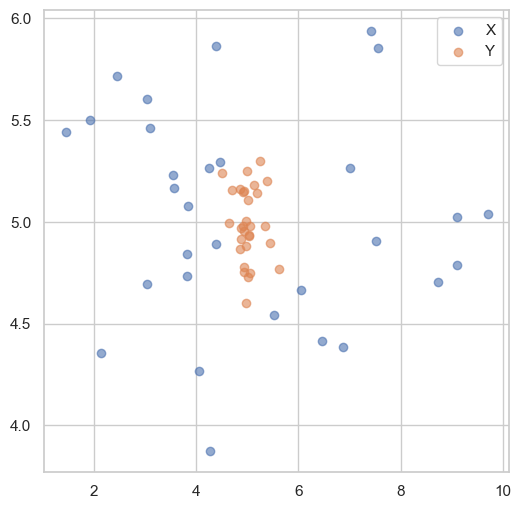

In [2]:
# generate two distributions in 2D
n_points = 30

X = np.array([np.random.normal(5, 2, n_points), np.random.normal(5, .5, n_points)]).T
Y = np.array([np.random.normal(5, .2, n_points), np.random.normal(5, .2, n_points)]).T

plt.figure(figsize=(figsize, figsize))

plt.scatter(X[:,0], X[:,1], alpha=0.6, label='X')
plt.scatter(Y[:,0], Y[:,1], alpha=0.6, label='Y')

plt.legend()
plt.show()

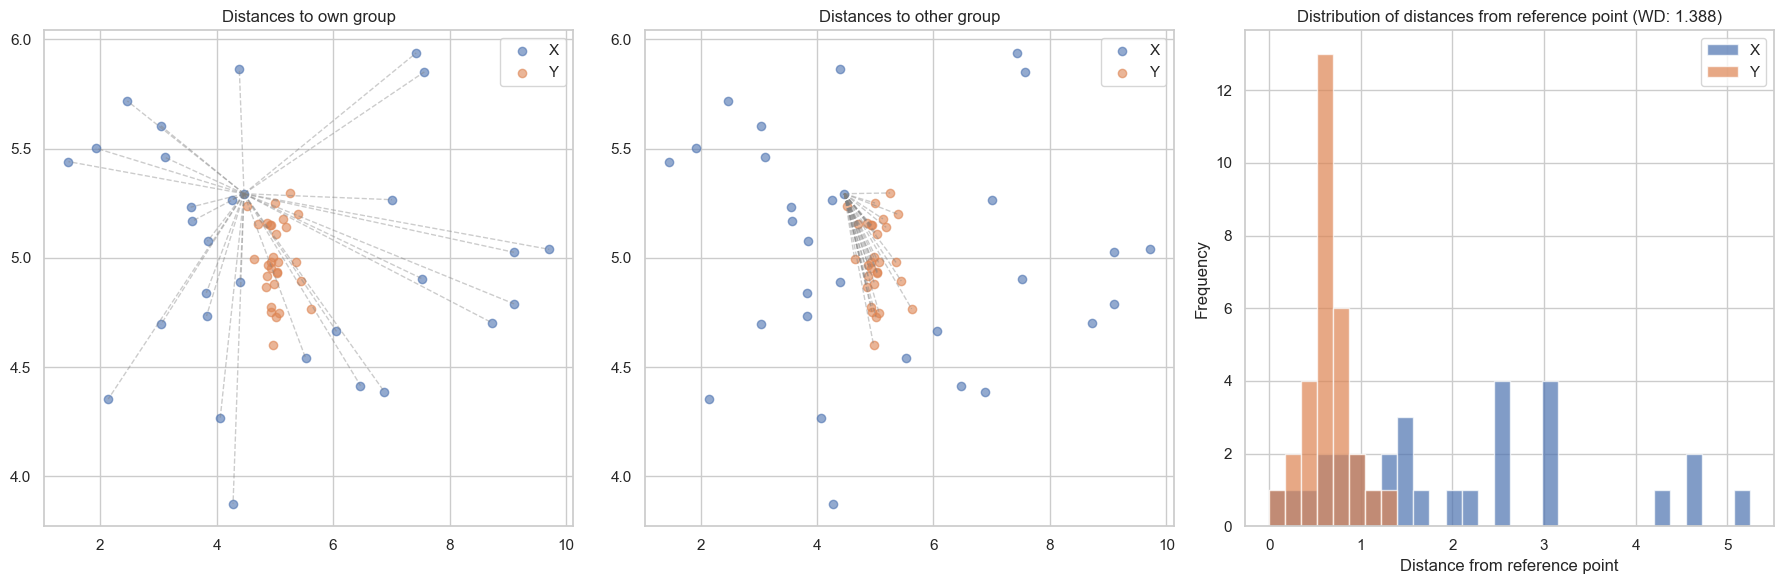

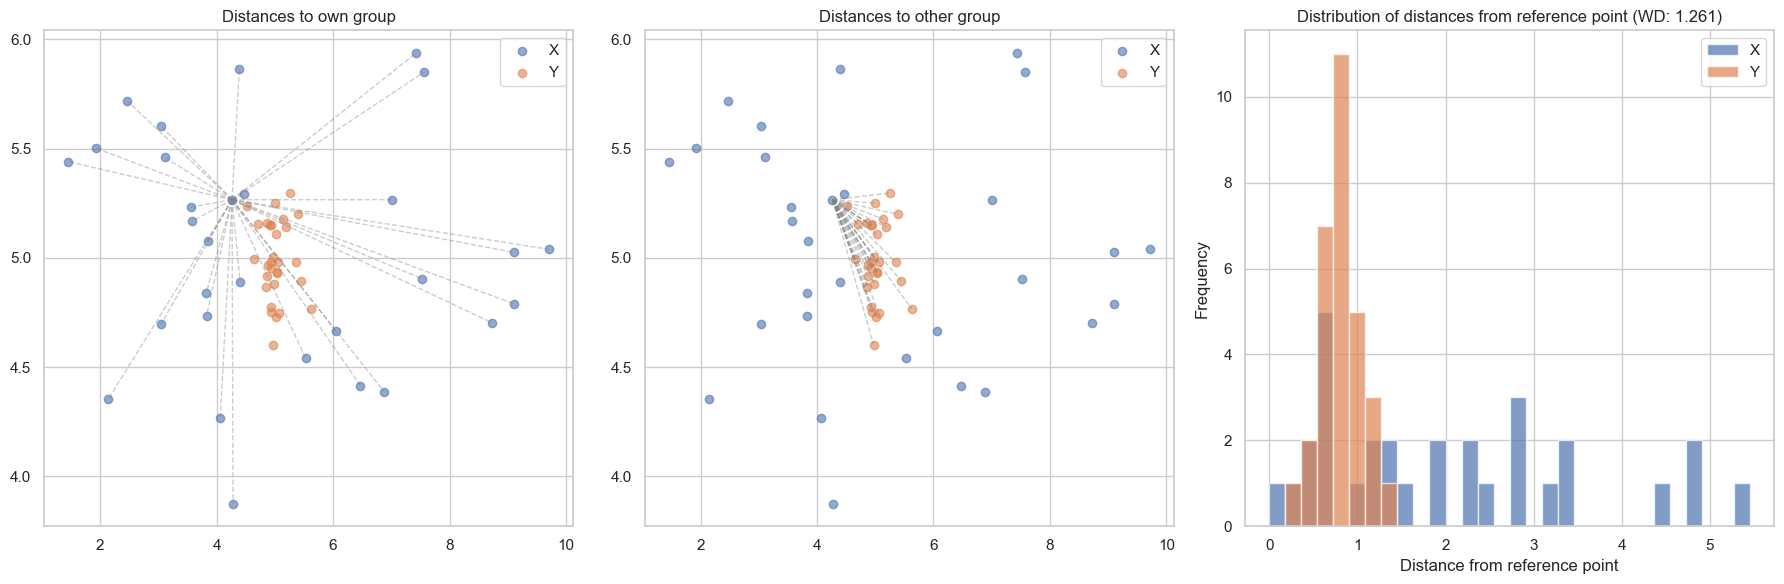

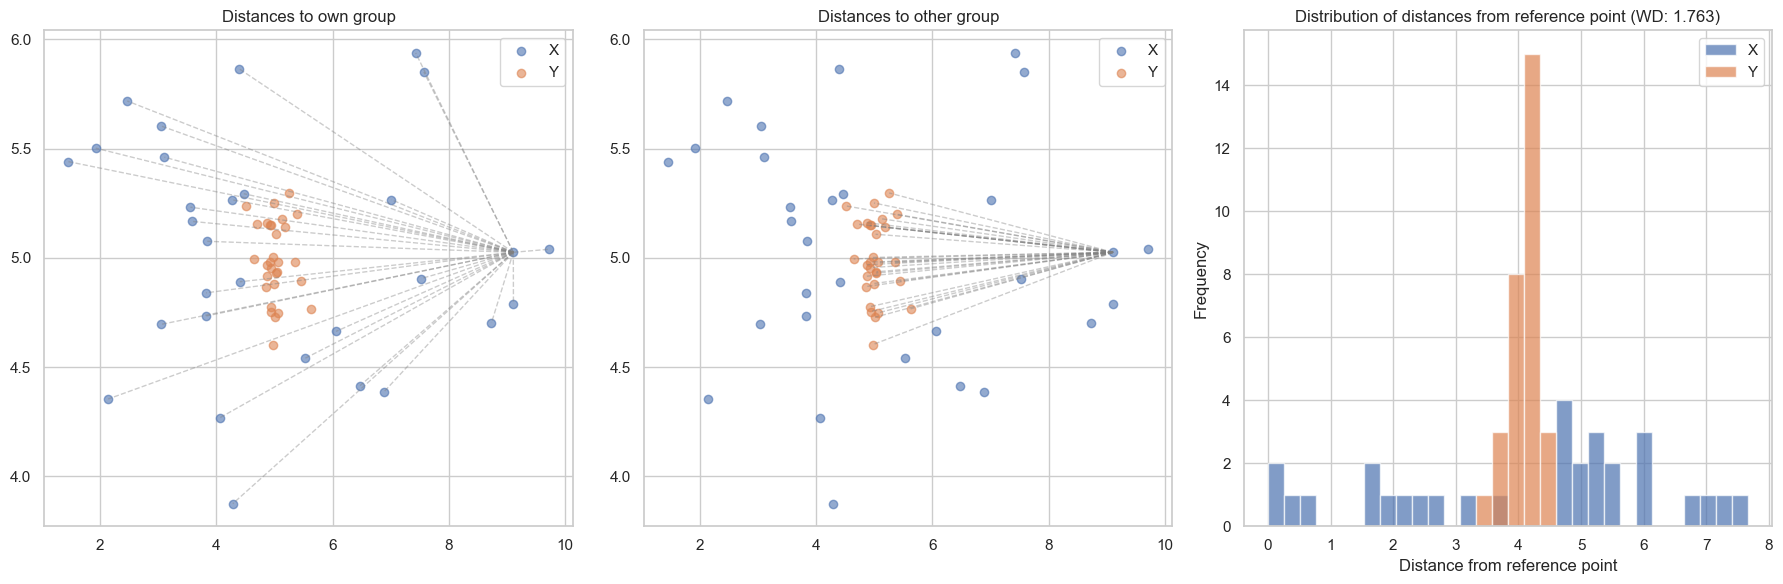

In [3]:
# the PED leverages every point in the reference samples to evaluate the average distance between empirical distributions;
# here we showcase how that looks like for a few of these points
for point_i in range(3):

    # 1) compute the distance between a reference point and the reference empirical distributions
    reference_point = X[point_i]
    distances = np.linalg.norm(X - reference_point, axis=1)

    plt.figure(figsize=(figsize*3, figsize))
    plt.subplot(1, 3, 1)
    
    for point in X:
        plt.plot([reference_point[0], point[0]], [reference_point[1], point[1]], 'grey', linestyle='--', linewidth=1, alpha=.4)

    plt.scatter(X[:,0], X[:,1], alpha=0.6, label='X')
    plt.scatter(Y[:,0], Y[:,1], alpha=0.6, label='Y')

    plt.legend(loc='upper right')
    plt.title('Distances to own group')
    
    plt.subplot(1, 3, 2)
    
    # 2) compute the distance between the reference point and the evaluated empirical distributions
    distances = np.linalg.norm(X - reference_point, axis=1)
    distances_eval = np.linalg.norm(Y - reference_point, axis=1)

    for point in Y:
        plt.plot([reference_point[0], point[0]], [reference_point[1], point[1]], 'grey', linestyle='--', linewidth=1, alpha=.4)

    plt.scatter(X[:,0], X[:,1], alpha=0.6, label='X')
    plt.scatter(Y[:,0], Y[:,1], alpha=0.6, label='Y')

    plt.legend(loc='upper right')
    plt.title('Distances to other group')

    plt.subplot(1, 3, 3)
    
    bins = np.histogram_bin_edges(np.concatenate([distances, distances_eval]), bins=n_points)

    plt.hist(distances, bins=bins, alpha=0.7, label='X')
    plt.hist(distances_eval, bins=bins, alpha=0.7, label='Y')

    # 3) compare the two 1D distances distributions induced by the reference point
    wd = scipy.stats.wasserstein_distance(distances, distances_eval)

    plt.legend(loc='upper right')
    plt.xlabel('Distance from reference point')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of distances from reference point (WD: {wd:.3f})')
    
    plt.tight_layout()
    plt.show()



This metric in itself represents a divergence in expected distance distributions, and is not in general symmetric.  
By computing this quantity in the other direction we get a true distance.  

Note: for advanced applications in settings where one distribution is fixed we can leverage the divergence instead of the true distance to significantly reduce the computational burden by saving much more than half of the total calculations, however in general one will get more resolution leveraging the true distance.

In [4]:
# the pointwise empirical distance can be computed using any measure of distance between 1D distributions;
# in this notebook we'll use the wasserstein distance
def compute_ped(X, Y):
    
    # safety check
    assert len(X) == len(Y), 'implementation requires equal samples; refactor comparing quantiles for asymmetric distributions'
    
    # we can use any distance defined in the space of interest; if it is a true distance, then the resulting 
    # metric will have the properties of a true distance as well; in this case we'll use the euclidean distance
    dXX = scipy.spatial.distance.cdist(X, X)
    dYY = scipy.spatial.distance.cdist(Y, Y)
    dXY = scipy.spatial.distance.cdist(X, Y)
    
    # compute XY Wasserstein divergence
    DXY = np.mean(np.abs(np.sort(dXX) - np.sort(dXY)))
    
    # compute YX Wasserstein divergence
    DYX = np.mean(np.abs(np.sort(dYY) - np.sort(dXY.T)))
    
    # the average divergence yields the empirical distance
    return (DXY + DYX) / 2

print(f'PED between X and Y: {compute_ped(X, Y):.2f}')
print(f'Wasserstein distance: {scipy.stats.wasserstein_distance_nd(X, Y):.2f}')

PED between X and Y: 1.57
Wasserstein distance: 1.87


# Statistical interpretation

We can also use the PED to get a probability estimate of the two empirical distributions being generated from the same distribution.

In [5]:
def distances_distribution(samples, n_bootstrap = 1000):
    '''
    bootstrap pointwise empirical divergence of an empirical distribution with respect to itself bootstrapped;
    return the resulting distances distribution, alongside the computed theoretical distribution
    '''
    # gather empirical PEDs
    peds = np.array([
        compute_ped(
            samples[np.random.choice(len(samples), len(samples))], 
            samples[np.random.choice(len(samples), len(samples))]
        ) for i in range(n_bootstrap)
    ])

    # we approximate these with a Gamma distribution to reduce the number of bootstraps required
    gamma_distribution = scipy.stats.gamma(*scipy.stats.gamma.fit(peds))
    
    # return empirical and theoretical distribution
    return peds, gamma_distribution

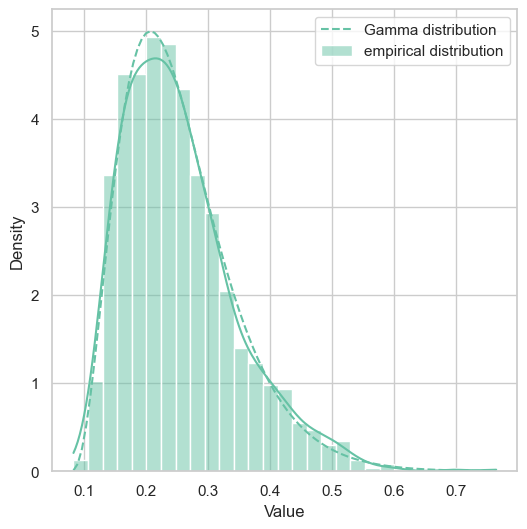

In [6]:
# compute empirical and gamma distribution
peds, dist = distances_distribution(np.concatenate([X, Y]))

# plot empirical vs theoretical
plt.figure(figsize=(figsize, figsize))

# empirical distribution
sns.histplot(peds, stat='density', kde=True, label='empirical distribution', alpha=.5, color='#66c2a5')

# theoretical distribution
x = np.linspace(min(peds), max(peds), 100)
plt.plot(x, dist.pdf(x), label='Gamma distribution', color='#66c2a5', linestyle='--')

# label and plot
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

We can therefore use the CDF of the fitted distribution for the expected PED to evaluate the probability of observing distances equal to or greater than the one registered when comparing the two actual distributions (permutation test)

In [7]:
# compute prob of observing a distance equal to or higher than the one observed from the candidate to the X
pval = 1 - dist.cdf(compute_ped(X, Y))
print(f'Probability of candidate samples sharing ground distribution with empirical {pval:.4f}')

Probability of candidate samples sharing ground distribution with empirical 0.0000


Another (less direct) approach to pvalue estimate can be to compute the null distribution for the two populations independently; although this might be slightly less powerful for standard statistical approaches, it can be extremely useful for some of the more advanced applications we will explore in the next notebook

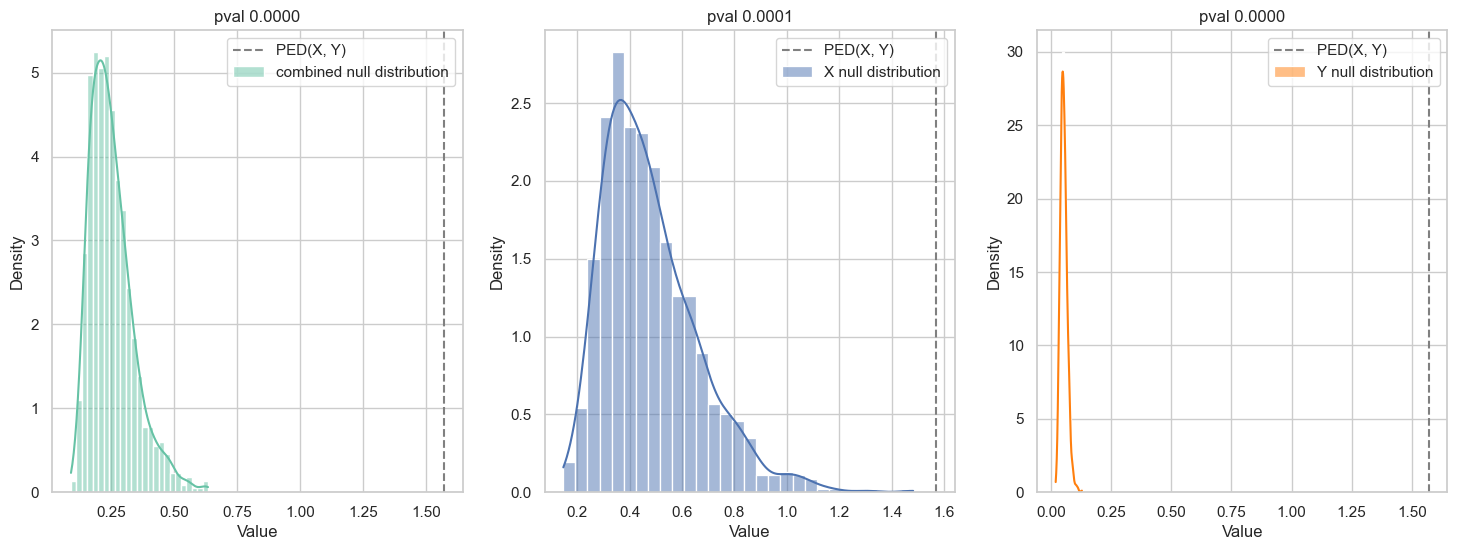

In [8]:
# combined distribution for permutation test
combined_peds, combined_dist = distances_distribution(np.concatenate([X, Y]))

# reference vs self
reference_peds, reference_dist = distances_distribution(X)

# candidate vs self
candidate_peds, candidate_dist = distances_distribution(Y)

# PED(X, Y)
dXY = compute_ped(X, Y)

# plot empirical vs theoretical
plt.figure(figsize=(figsize*3, figsize))
plt.subplot(1, 3, 1)

# empirical distribution
sns.histplot(combined_peds, stat='density', kde=True, label='combined null distribution', color='#66c2a5')
plt.axvline(x=dXY, color='grey', label='PED(X, Y)', linestyle='--')

# label and plot
plt.xlabel('Value')
plt.ylabel('Density')
plt.title(f'pval { 1 - combined_dist.cdf(dXY):.4f}')
plt.legend(loc='upper right')

plt.subplot(1, 3, 2)

# empirical distribution
sns.histplot(reference_peds, stat='density', kde=True, label='X null distribution')
plt.axvline(x=dXY, color='grey', label='PED(X, Y)', linestyle='--')

# label and plot
plt.xlabel('Value')
plt.ylabel('Density')
plt.title(f'pval { 1 - reference_dist.cdf(dXY):.4f}')
plt.legend(loc='upper right')

plt.subplot(1, 3, 3)

# empirical distribution
sns.histplot(candidate_peds, stat='density', kde=True, label='Y null distribution', color='#ff7f0e')

plt.axvline(x=dXY, color='grey', label='PED(X, Y)', linestyle='--')

# label and plot
plt.xlabel('Value')
plt.ylabel('Density')
plt.title(f'pval { 1 - candidate_dist.cdf(dXY):.4f}')
plt.legend(loc='upper right')

plt.show()

We document a few practical examples of how the pvalue might result from comparing different distributions (as well as cases in which the metric will fail)  
Note that in general there will be no correlation between pointwise empirical distances and probability of distributions being close together, as they pertain two entirely different domains  

In [9]:
def ped_pval(X, Y, n_bootstrap = 1000):
    
    # compute distributions PED
    ped = compute_ped(X, Y)
    
    # compare two PED null distributions and return the lowest pval
    return  min(1 - distances_distribution(X)[1].cdf(ped), 1 - distances_distribution(Y)[1].cdf(ped))

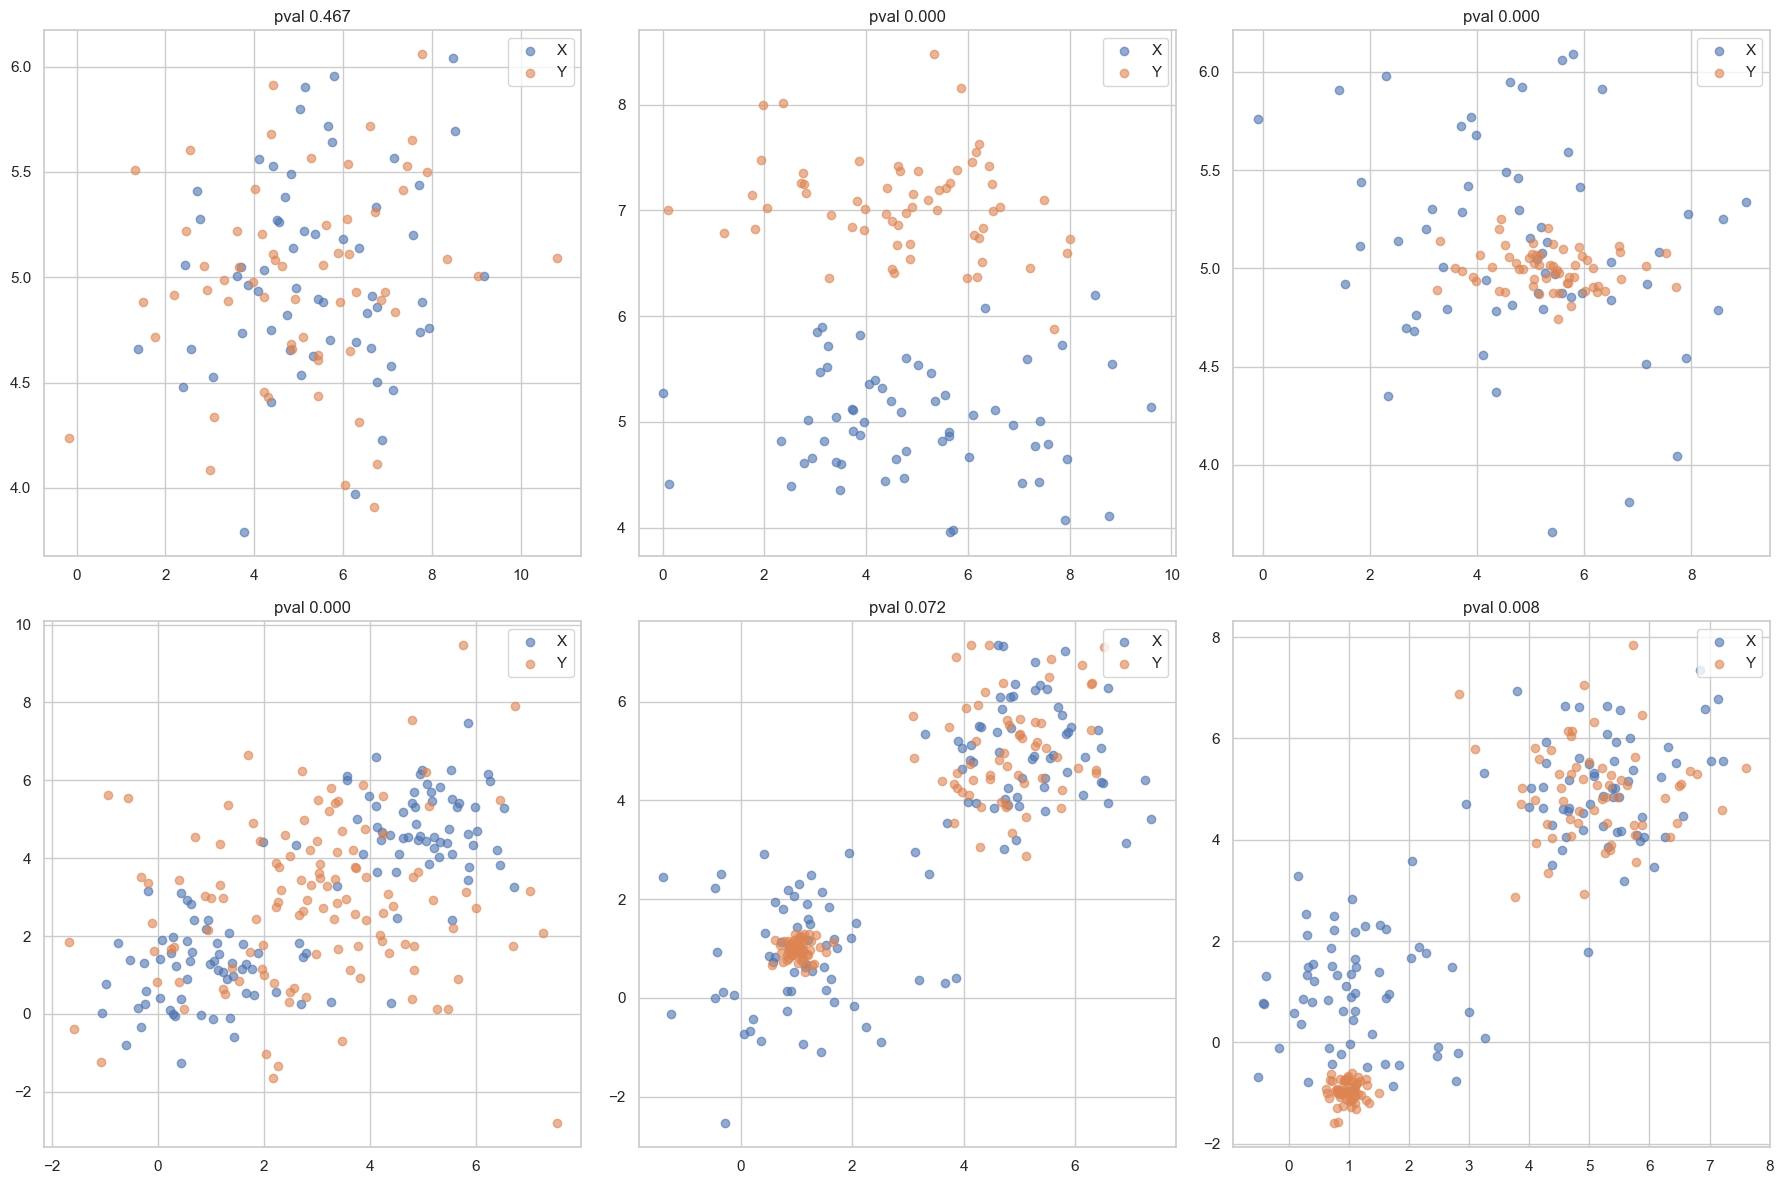

In [10]:
# list of normal distributions to compare
compare_dist = [
    
    # one element per example
    # for each example: reference and candidate
    # for each distribution: list of Gaussian mixtures
    # for each Gaussian: mean_x, mean_y, scale_x, scale_y
    
    [
        # identical distributions
        [[5, 5, 2, .5]],
        [[5, 5, 2, .5]],
    ],
    [
        # intersecting distributions
        [[5, 5, 2, .5]],
        [[5, 7, 2, .5]],
    ],
    [
        # concentric distributions
        [[5, 5, 2, .5]],
        [[5, 5, 1, .1]],
    ],
    
    [
        # multimodal vs unimodal
        [[5, 5, 1, 1], [1, 1, 1, 1]],
        [[3, 3, 2, 2], [3, 3, 2, 2]],
    ],
    [
        # concentric multimodal distributions, hard case
        [[5, 5, 1, 1], [1, 1, 1, 1]],
        [[5, 5, 1, 1], [1, 1, .2, .2]],
    ],
    [
        # concentric multimodal distributions, simple case
        [[5, 5, 1, 1], [1, 1, 1, 1]],
        [[5, 5, 1, 1], [1, -1, .2, .2]],
        
    ],
]

# plot initial population expansion on a 2x3 grid, flattening the axes for ease of iteration
fig, axes = plt.subplots(2, 3, figsize=(figsize*3, figsize*2))
axes = axes.flatten()

# sample size
n_samples = 60

for i in range(6):
    
    # sample points from first distribution
    X = np.concatenate([
        np.array([np.random.normal(mean_x, scale_x, n_samples), np.random.normal(mean_y, scale_y, n_samples)]).T
        for mean_x, mean_y, scale_x, scale_y in compare_dist[i][0]
    ])
    
    # sample points from second distribution
    Y = np.concatenate([
        np.array([np.random.normal(mean_x, scale_x, n_samples), np.random.normal(mean_y, scale_y, n_samples)]).T
        for mean_x, mean_y, scale_x, scale_y in compare_dist[i][1]
    ])
    
    # plot distributions
    axes[i].scatter(X[:,0], X[:,1], alpha=0.6, label='X')
    axes[i].scatter(Y[:,0], Y[:,1], alpha=0.6, label='Y')

    axes[i].legend(loc='upper right')
    axes[i].set_title(f'pval {ped_pval(X, Y):.3f}')

plt.tight_layout()
plt.show()

Following some PED examples on more exotic distributions to wrap up the notebook, feel free to expand and play around with the functions by adding more!

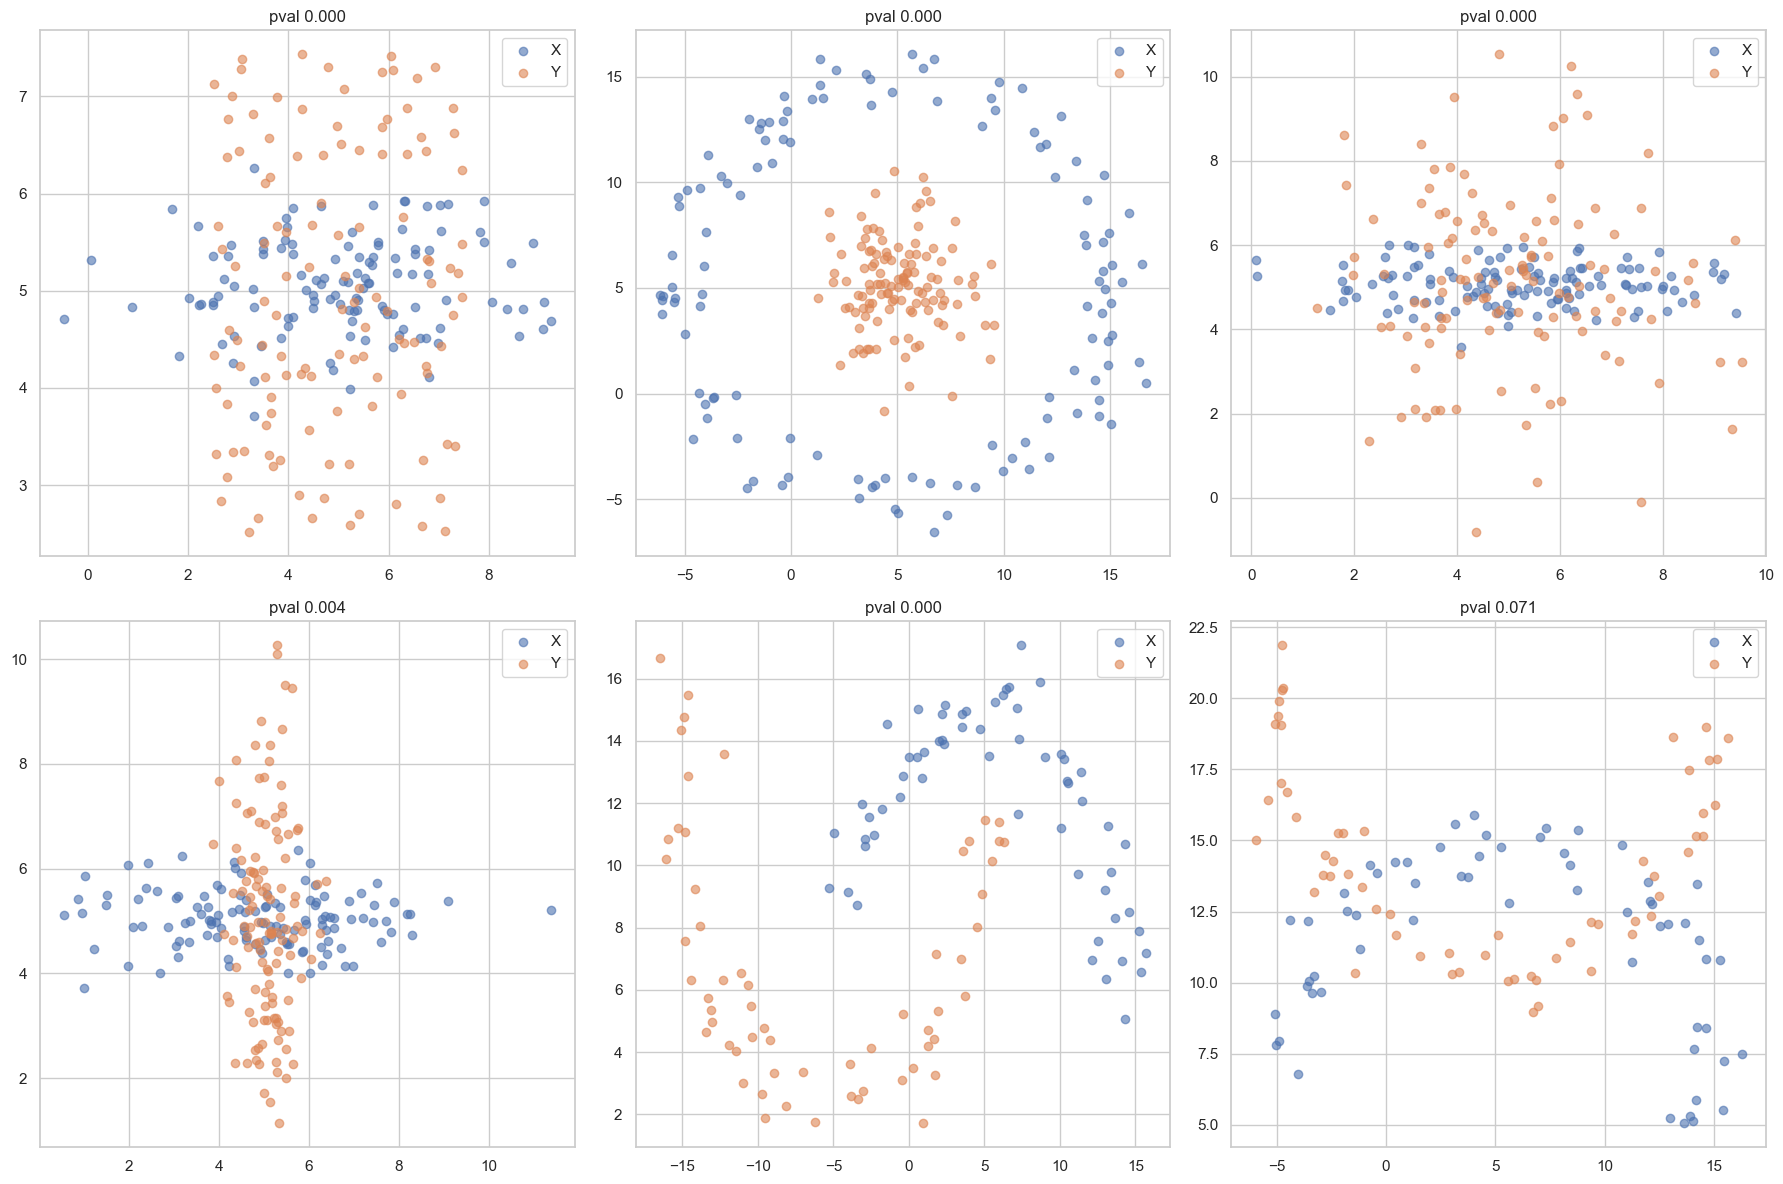

In [11]:
# extract plotting function from above
def compare_and_plot(axes, X, Y):
    
    # plot distributions
    axes.scatter(X[:,0], X[:,1], alpha=0.6, label='X')
    axes.scatter(Y[:,0], Y[:,1], alpha=0.6, label='Y')

    axes.legend(loc='upper right')
    axes.set_title(f'pval {ped_pval(X, Y):.3f}')
    
# make some plots
fig, axes = plt.subplots(2, 3, figsize=(figsize*3, figsize*2))
axes = axes.flatten()

n_points, plot_i = 120, 0

# uniform vs normal, simple
dA = np.array([np.random.normal(5, 2, n_points), np.random.normal(5, .5, n_points)]).T
dB = np.array([np.random.uniform(2.5, 7.5, n_points), np.random.uniform(2.5, 7.5, n_points)]).T

compare_and_plot(axes[plot_i], dA, dB); plot_i += 1

# bullseye distribution
angles = np.random.uniform(0, 2 * np.pi, n_points)
radii = np.random.normal(10, 1, n_points)

dA = np.vstack((radii * np.cos(angles), radii * np.sin(angles))).T + 5
dB = np.array([np.random.normal(5, 2, n_points), np.random.normal(5, 2, n_points)]).T

compare_and_plot(axes[plot_i], dA, dB); plot_i += 1

# flattened bullseye
angles = np.random.uniform(0, 2 * np.pi, n_points)
radii = np.random.normal(10, 1, n_points)

dA = np.vstack((radii * np.cos(angles), radii * np.sin(angles))).T + 5
dA = np.array([np.random.normal(5, 2, n_points), np.random.normal(5, .5, n_points)]).T

compare_and_plot(axes[plot_i], dA, dB); plot_i += 1

# uniform vs normal
dA = np.array([np.random.normal(5, 2, n_points), np.random.normal(5, .5, n_points)]).T
dB = np.array([np.random.normal(5, .5, n_points), np.random.normal(5, 2, n_points)]).T

compare_and_plot(axes[plot_i], dA, dB); plot_i += 1

# non intersecting Us
angles = np.random.uniform(0, 2 * np.pi, n_points)
radii = np.random.normal(10, 1, n_points)
mask = angles < np.median(angles)  # split in two equally sized distributions

dA = np.vstack((radii[mask] * np.cos(angles[mask]), radii[mask] * np.sin(angles[mask]))).T + 5
dB = np.vstack((radii[~mask] * np.cos(angles[~mask]), radii[~mask] * np.sin(angles[~mask]))).T + [-5, 12]

compare_and_plot(axes[plot_i], dA, dB); plot_i += 1

# intersecting Us
angles = np.random.uniform(0, 2 * np.pi, n_points)
radii = np.random.normal(10, 1, n_points)
mask = angles < np.median(angles)  # split in two equally sized distributions

dA = np.vstack((radii[mask] * np.cos(angles[mask]), radii[mask] * np.sin(angles[mask]))).T + 5
dB = np.vstack((radii[~mask] * np.cos(angles[~mask]), radii[~mask] * np.sin(angles[~mask]))).T + [5, 20]

compare_and_plot(axes[plot_i], dA, dB); plot_i += 1

plt.tight_layout()
plt.show()